In [427]:
from helpers.utils import read_csv, MAPE
import lightgbm as lgb
import pandas as pd
import gc
import datetime
import numpy as np
import matplotlib.pyplot as plt
from fbprophet import Prophet
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.base import clone
from sklearn.model_selection import check_cv
from category_encoders import CatBoostEncoder
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
import shap

pd.set_option("display.max_columns", 999)

In [382]:
def cyclic_encoding(df, col):
    
    max_val = df[col].max()
    df[col + '_sin'] = np.sin(2 * np.pi * df[col]/max_val)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col]/max_val)
    
    return df.drop([col], axis=1)


class TargetEncoderCV(BaseEstimator, TransformerMixin):
    '''
    Fold-based target encoder robust to overfitting
    '''

    def __init__(self, cv, **cbe_params):
        self.cv = cv
        self.cbe_params = cbe_params

    @property
    def _n_splits(self):
        return check_cv(self.cv).n_splits

    def fit_transform(self, X: pd.DataFrame, y) -> pd.DataFrame:
        self.cbe_ = []
        cv = check_cv(self.cv)
        cbe = CatBoostEncoder(
            cols=X.columns.tolist(),
            return_df=False,
            **self.cbe_params)

        X_transformed = np.zeros_like(X, dtype=np.float64)
        for train_idx, valid_idx in cv.split(X, y):
            self.cbe_.append(clone(cbe).fit(X.loc[train_idx], y[train_idx]))
            X_transformed[valid_idx] = self.cbe_[-1].transform(X.loc[valid_idx])
        return pd.DataFrame(X_transformed, columns=X.columns)

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X_transformed = np.zeros_like(X, dtype=np.float64)
        for cbe in self.cbe_:
            X_transformed += cbe.transform(X) / self._n_splits
        return pd.DataFrame(X_transformed, columns=X.columns)

In [4]:
sales = read_csv(r'data/sales.csv')
taxonomy = read_csv(r'data/product_taxonomy.csv')
stores = read_csv(r'data/store_cities.csv')

D:\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (10,12) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Mem. usage decreased from 8412.51 Mb to 8004.33 Mb (4.9% reduction)
Mem. usage decreased from  0.31 Mb to  0.31 Mb (2.6% reduction)
Mem. usage decreased from  0.03 Mb to  0.03 Mb (3.6% reduction)


In [5]:
data = pd.merge(sales, taxonomy, how='inner', on = ['product_id'])\
         .merge(stores, how='inner', on = ['store_id'])

del sales, taxonomy, stores
gc.collect()

20

In [27]:
data[data.sales == 0.017999999225139618]

,product_id,store_id,date,sales,revenue,stock,price,promo_type_1,promo_bin_1,promo_type_2,promo_bin_2,promo_discount_2,promo_discount_type_2,product_length,product_depth,product_width,cluster_id,hierarchy1_id,hierarchy2_id,hierarchy3_id,hierarchy4_id,hierarchy5_id,storetype_id,store_size,city_id,weekday,week,month,quarter,year,year_month,year_quarter
1326719,P0561,S0040,2018-12-17,0.018,0.44,0.0,25.9,PR14,NaN,PR03,NaN,NaN,NaN,1.0,1.0,1.0,cluster_0,H00,H0004,H000403,H00040305,H0004030536,ST04,42,C017,0,51,12,4,2018,2018-12,2018Q4
8776334,P0316,S0028,2018-02-17,0.018,1.25,0.0,NaN,PR14,NaN,PR03,NaN,NaN,NaN,1.0,1.0,1.0,cluster_0,H00,H0004,H000403,H00040300,H0004030017,ST01,86,C036,5,7,2,1,2018,2018-02,2018Q1


In [74]:
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data[(data.date <= datetime.datetime(2019, 10, 31))]


data['weekday'] = data.date.dt.dayofweek
data['week'] = data.date.dt.isocalendar().week
data['month'] = data.date.dt.month
data['quarter'] = data.date.dt.quarter
data['year'] = data.date.dt.year
data['year_month'] = data.date.dt.strftime('%Y-%m')
data['date_month'] = data.date.dt.strftime('%m-%d')
data['year_quarter'] = pd.PeriodIndex(data.date, freq='Q')
data['weekday_week'] = data['week'].astype(str) + '-' + data['weekday'].astype(str)
data['year_week'] = data['year'].astype(str) + '-' + data['week'].astype(str)

# Baselines

We need to make daily forecasting for October 2019. Before going to complex models I want to try few simple baselines

- average based on seasonality (average sales by same dates in previous years multiplied by YoY trend)
- Facebook Prophet

In [158]:
grouped = data.groupby(['date', 'date_month', 'weekday_week', 'year', 'hierarchy1_id', 'storetype_id'])['sales'].sum().reset_index()
grouped.sort_values(by=['hierarchy1_id', 'storetype_id', 'date'], inplace=True)

In [159]:
grouped.head()

,date,date_month,weekday_week,year,hierarchy1_id,storetype_id,sales
0,2017-01-02,01-02,1-0,2017,H00,ST01,767.294006
16,2017-01-03,01-03,1-1,2017,H00,ST01,605.481995
32,2017-01-04,01-04,1-2,2017,H00,ST01,717.250000
48,2017-01-05,01-05,1-3,2017,H00,ST01,642.557983
64,2017-01-06,01-06,1-4,2017,H00,ST01,712.955994


In [160]:
predictions = grouped[grouped.date.between(datetime.datetime(2019, 10, 1), datetime.datetime(2019, 10, 31))].copy()

In [161]:
grouped = grouped[grouped.date < datetime.datetime(2019, 10, 1)]

In [162]:
prediction_pairs = data[['hierarchy1_id', 'storetype_id']].drop_duplicates()

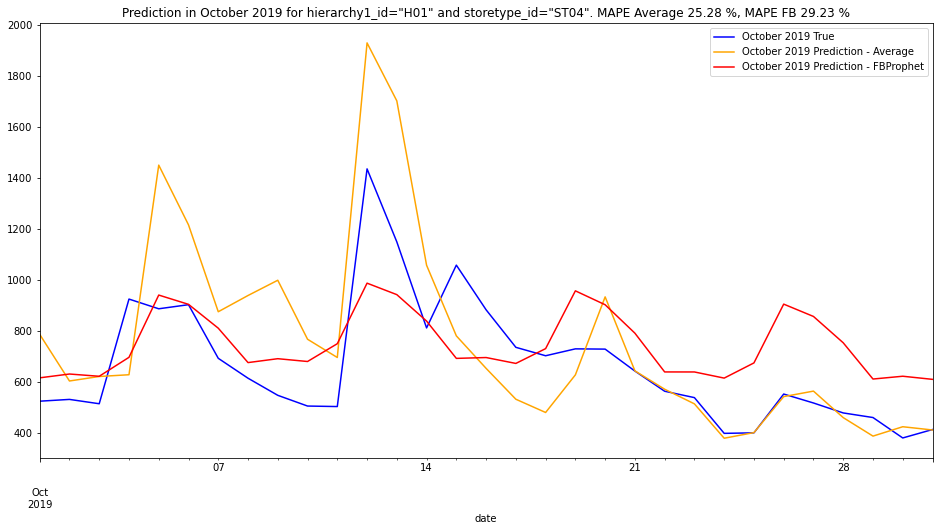

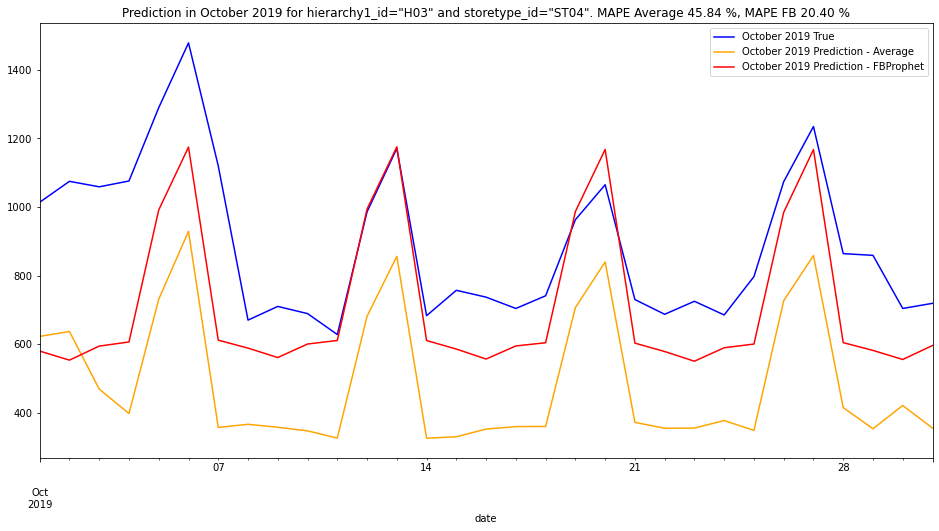

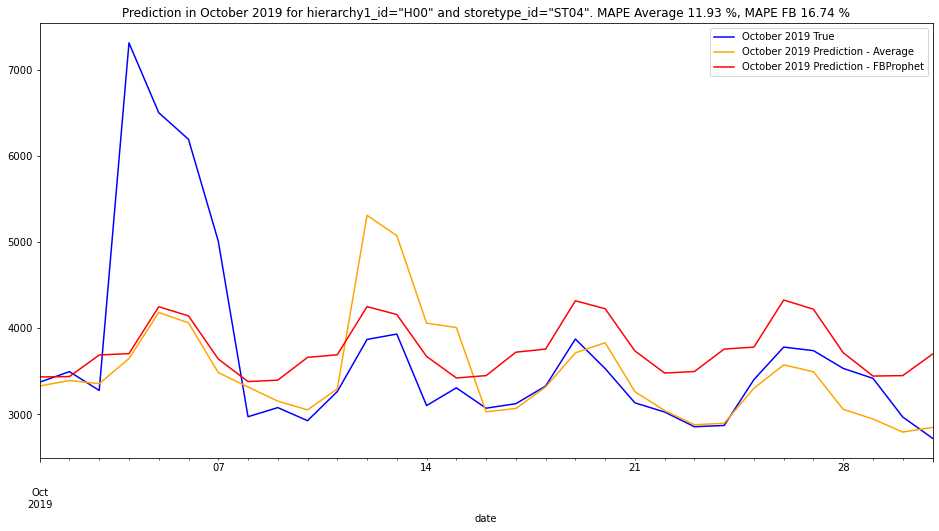

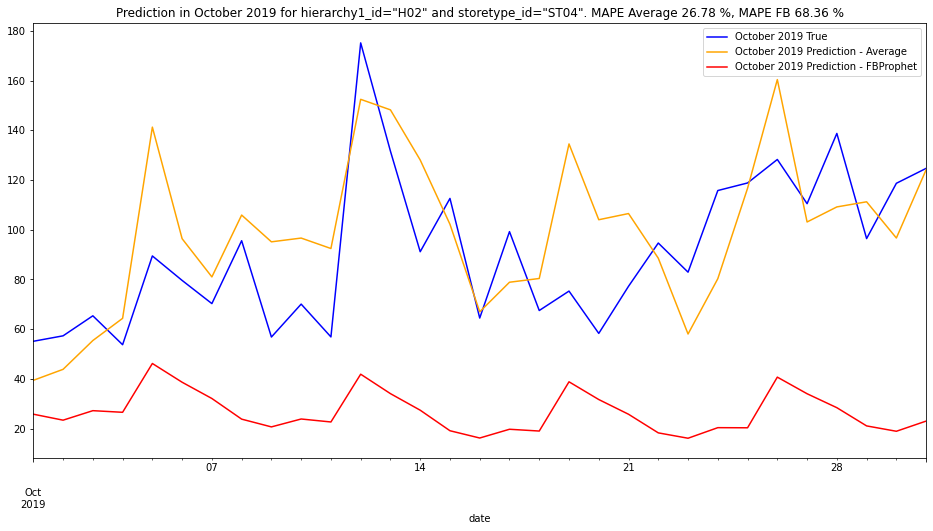

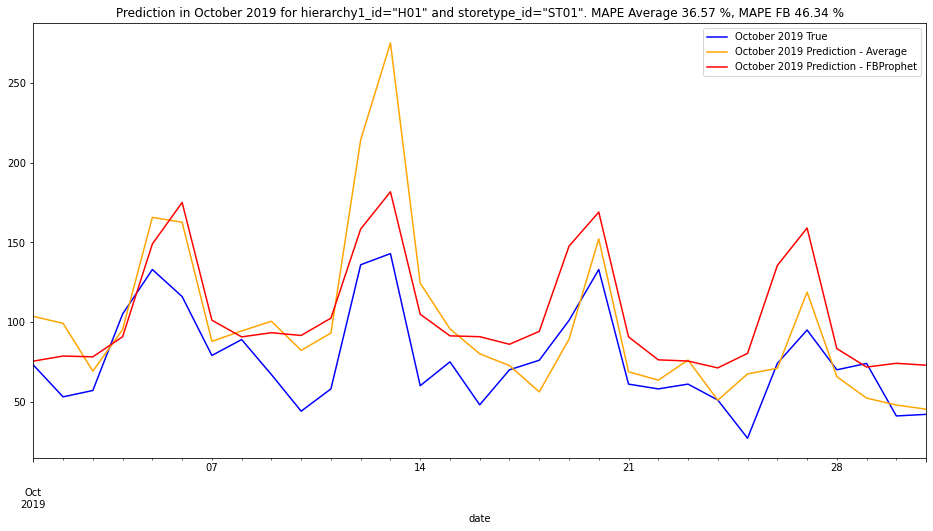

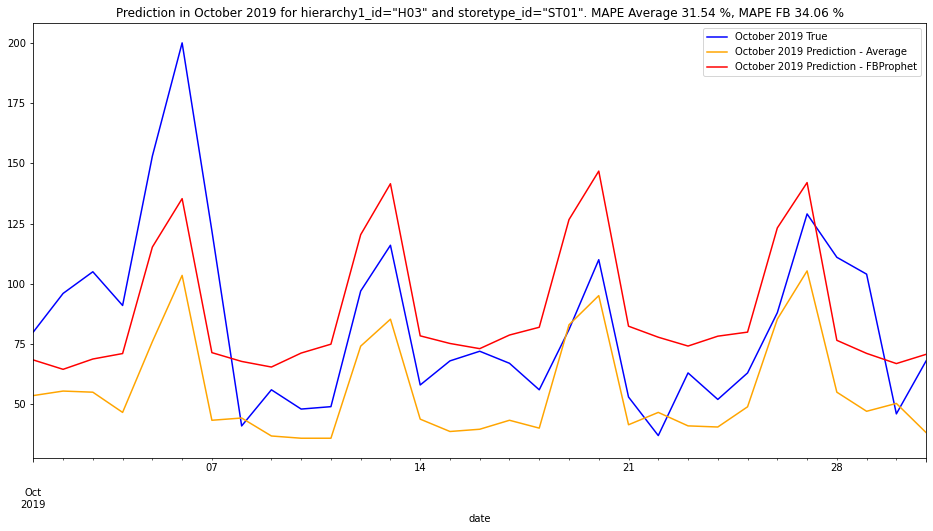

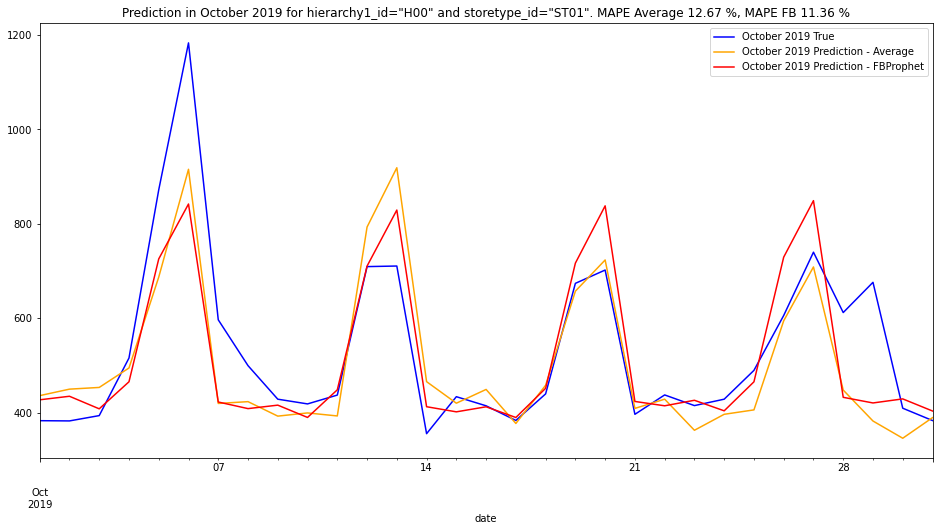

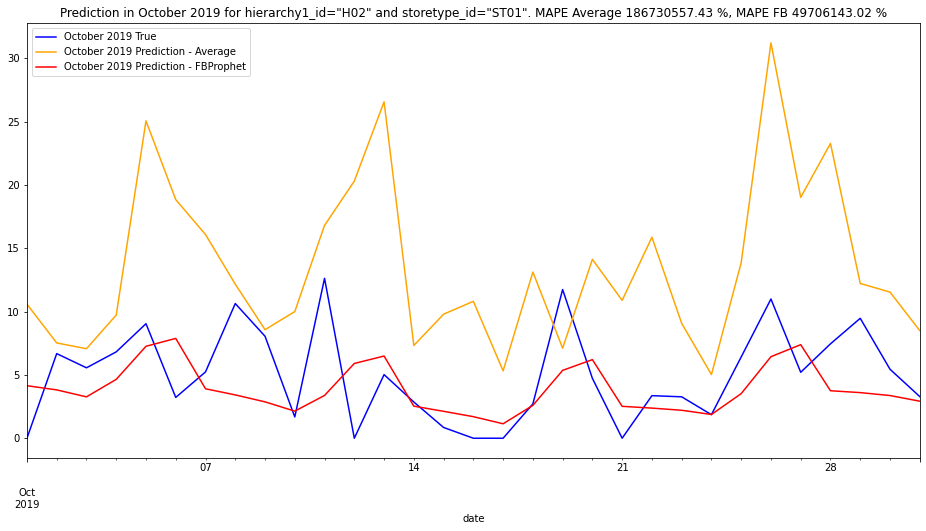

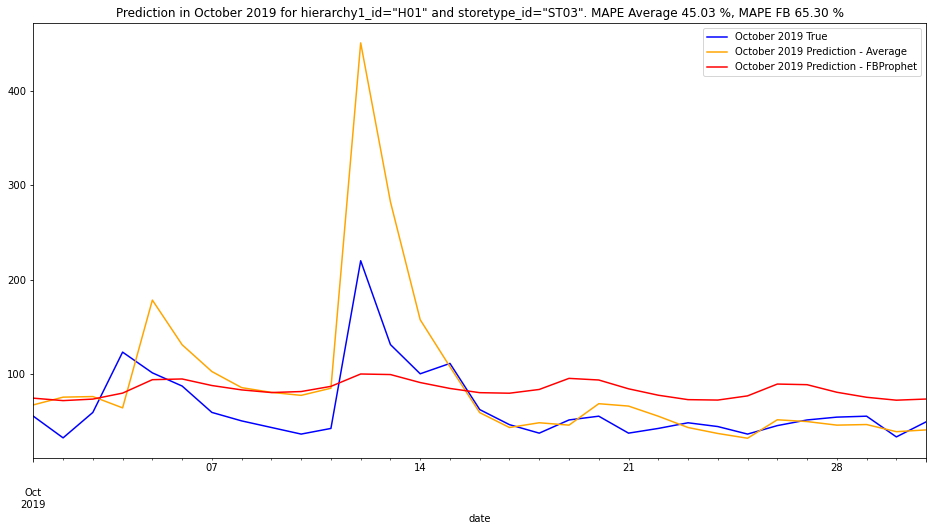

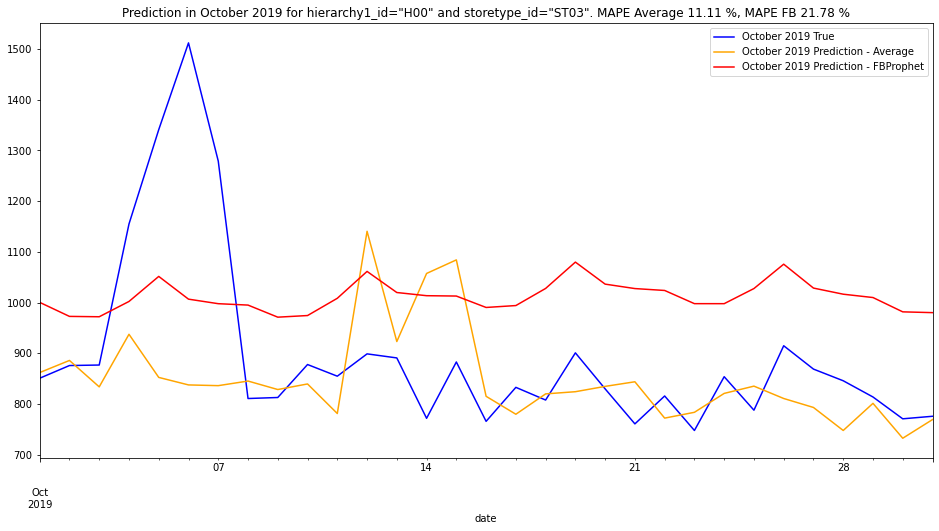

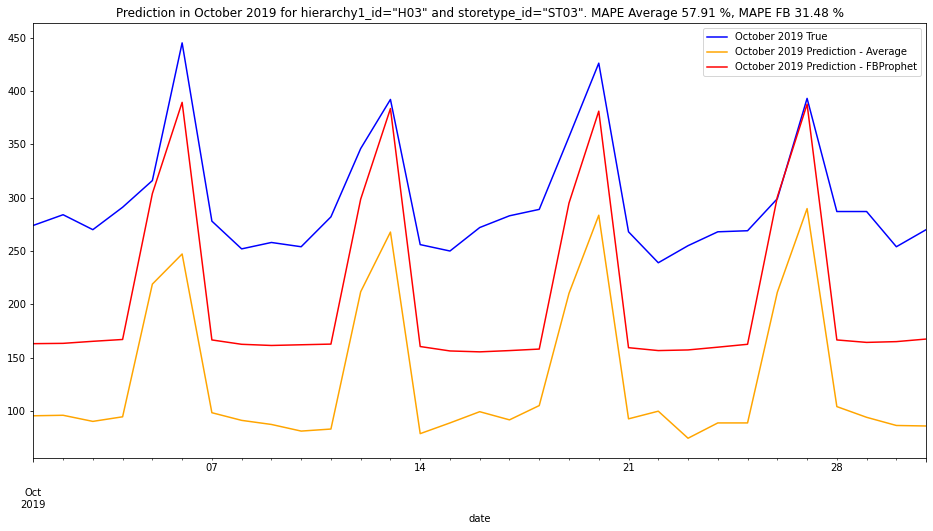

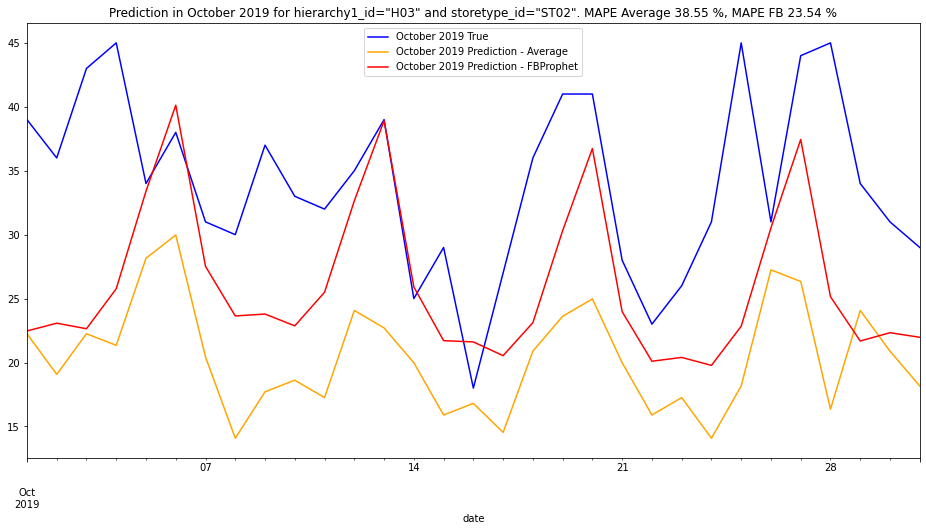

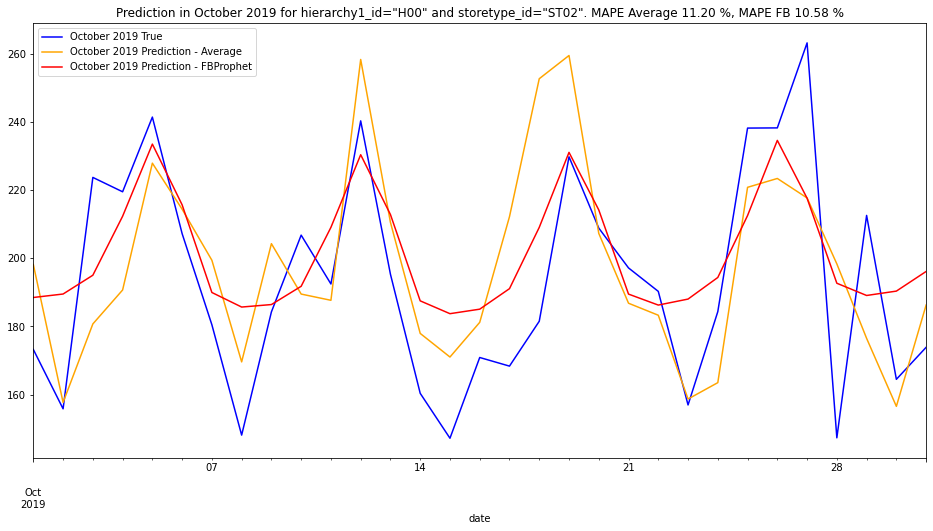

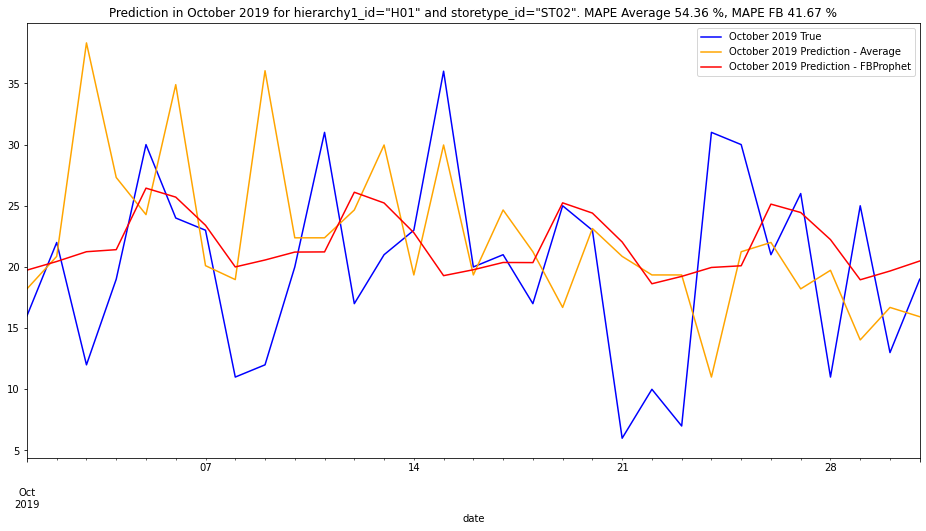

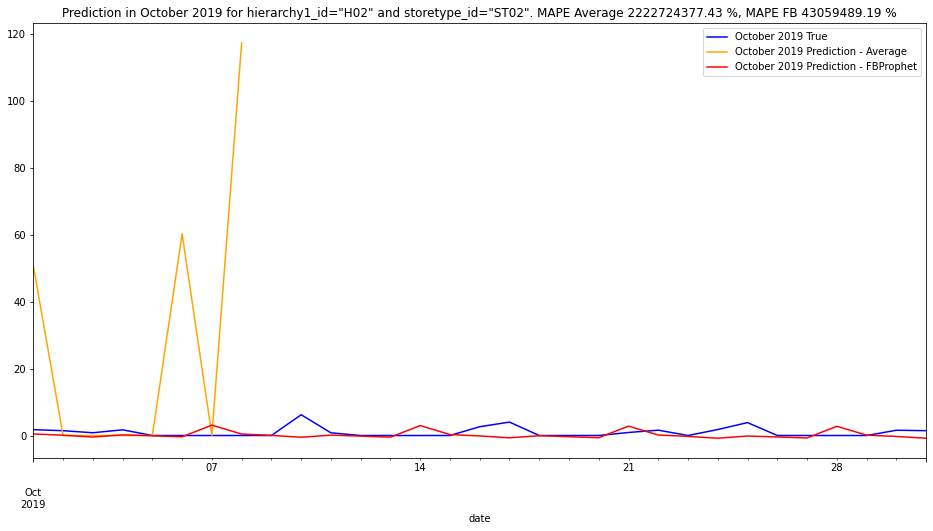

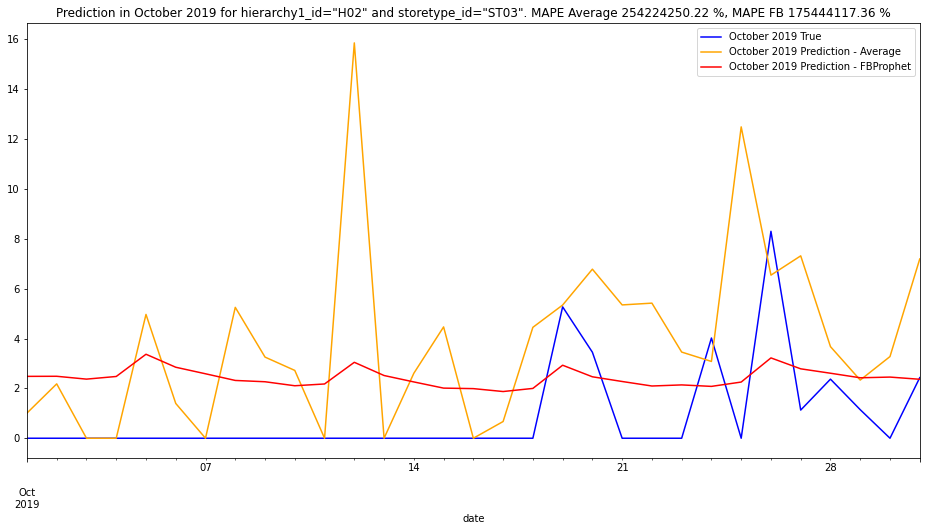

In [165]:
predictions['average_prediction'] = 0
predictions['fbprophet'] = 0

for pair in prediction_pairs.to_numpy():
    
    # Based on seasonal average
    avg = grouped[(grouped.hierarchy1_id == pair[0]) & 
                    (grouped.storetype_id == pair[1])].groupby(['weekday_week'])['sales'].mean().to_dict()
    trend = grouped[(grouped.hierarchy1_id == pair[0]) & 
                     (grouped.storetype_id == pair[1]) & 
                     (grouped.year == 2019)
                    ]['sales'].sum() / \
            grouped[(grouped.hierarchy1_id == pair[0]) & 
                     (grouped.storetype_id == pair[1]) & 
                     (grouped.year == 2018) &
                     (grouped.date_month.between('01-01', '09-30'))
                    ]['sales'].sum()
    predictions.loc[(predictions.hierarchy1_id == pair[0]) & 
                    (predictions.storetype_id == pair[1]), 'average_prediction'] = \
    predictions[(predictions.hierarchy1_id == pair[0]) & 
                    (predictions.storetype_id == pair[1])]['weekday_week'].map(avg)*trend
    
    # Facebook's Prophet
    prophet = Prophet(daily_seasonality=True, weekly_seasonality=True, 
                      yearly_seasonality=False, changepoint_prior_scale=0.01)
    prophet.add_seasonality(name='monthly', period=30.5, fourier_order=1)
    prophet.fit(grouped[(grouped.hierarchy1_id == pair[0]) & 
                    (grouped.storetype_id == pair[1])].rename(columns={"date" : 'ds', 'sales' : 'y'})[['ds', 'y']])
    
    prediction_preds = prophet.predict(predictions[(predictions.hierarchy1_id == pair[0]) & 
                    (predictions.storetype_id == pair[1])].rename(columns={"date" : 'ds', 'sales' : 'y'})[['ds', 'y']])[['ds', 'yhat']]
    
    predictions.loc[(predictions.hierarchy1_id == pair[0]) & 
                    (predictions.storetype_id == pair[1]), 'fbprophet'] = prediction_preds.yhat.values
    
    # Plot charts
    predictions[(predictions.hierarchy1_id == pair[0]) & 
                    (predictions.storetype_id == pair[1])].set_index('date')['sales'].plot(figsize=(16,8), label='October 2019 True', c='blue')
    predictions[(predictions.hierarchy1_id == pair[0]) & 
                    (predictions.storetype_id == pair[1])].set_index('date')['average_prediction'].plot(figsize=(16,8), label='October 2019 Prediction - Average', c='orange')
    predictions[(predictions.hierarchy1_id == pair[0]) & 
                    (predictions.storetype_id == pair[1])].set_index('date')['fbprophet'].plot(figsize=(16,8), label='October 2019 Prediction - FBProphet', c='red')
    
    mape_average = \
    MAPE(predictions[(predictions.hierarchy1_id == pair[0]) & 
                    (predictions.storetype_id == pair[1])]['sales'], predictions[(predictions.hierarchy1_id == pair[0]) & 
                    (predictions.storetype_id == pair[1])]['average_prediction'])
    
    mape_fb = \
    MAPE(predictions[(predictions.hierarchy1_id == pair[0]) & 
                    (predictions.storetype_id == pair[1])]['sales'], predictions[(predictions.hierarchy1_id == pair[0]) & 
                    (predictions.storetype_id == pair[1])]['fbprophet'])
    
    plt.title('Prediction in October 2019 for hierarchy1_id="{0}" and storetype_id="{1}". MAPE Average {2:0.2f} %, MAPE FB {3:0.2f} %'\
                  .format(pair[0], pair[1], mape_average, mape_fb))
    plt.legend()
    plt.show()

# Recursive lightGBM model

Recursive approach is based on using predictions as features for new predictions. E. g. we predicted sales for January 1st to use this prediction as a feature for January 2nd

In [342]:
base_data = data.groupby(['date', 'hierarchy1_id', 'storetype_id', 'weekday', 'week', 'month',
                          'quarter', 'year', 'year_month', 'year_quarter', 'date_month',
                          'weekday_week', 'year_week'])['sales'].sum()\
                .reset_index()\
                .sort_values(by=['hierarchy1_id', 'storetype_id', 'date'])

## Product features

In [343]:
def add_month_to_year_month(year_month, offset=1):
    year_month = pd.to_datetime(year_month, format='%Y-%m') + pd.DateOffset(months=offset)
    return year_month.dt.strftime('%Y-%m')

In [344]:
product_features = data.groupby(['hierarchy1_id', 'storetype_id', 'year_month']).agg({'product_id' : 'nunique',
                                                                                'product_length' :  [np.min, np.mean, np.max],
                                                                                 'product_depth' : [np.min, np.mean, np.max],
                                                                                 'product_width' : [np.min, np.mean, np.max],
                                                                                 'store_id' : 'nunique',
                                                                                 'store_size' : [np.min, np.mean, np.max],
                                                                                 'price' : [np.min, np.mean, np.max]
                                                                                }).reset_index()

product_features.columns = ['hierarchy1_id', 'storetype_id', 'year_month', 'number_of_products', 
                            'product_length_min', 'product_length_mean', 'product_length_max',
                            'product_depth_min', 'product_depth_mean', 'product_depth_max',
                            'product_width_min', 'product_width_mean', 'product_width_max', 'number_of_stores',
                            'store_size_min', 'store_size_mean', 'store_size_max', 'price_min', 'price_mean', 'price_max']

In [345]:
product_features.head()

,hierarchy1_id,storetype_id,year_month,number_of_products,product_length_min,product_length_mean,product_length_max,product_depth_min,product_depth_mean,product_depth_max,product_width_min,product_width_mean,product_width_max,number_of_stores,store_size_min,store_size_mean,store_size_max,price_min,price_mean,price_max
0,H00,ST01,2017-01,100,0.5,5.051656,14.0,1.0,15.255520,34.5,1.0,10.372574,20.0,4,60,66.046775,86,0.25,6.053285,59.900002
1,H00,ST01,2017-02,99,0.5,5.034553,13.0,1.0,15.189687,34.5,1.0,10.336359,20.0,4,60,66.036745,86,0.25,6.082590,59.900002
2,H00,ST01,2017-03,100,0.5,5.048532,13.0,1.0,15.142008,34.5,1.0,10.338576,20.0,4,60,66.027252,86,0.25,6.113890,59.900002
3,H00,ST01,2017-04,101,0.5,5.116202,13.0,1.0,15.415567,34.5,1.0,10.302265,20.0,4,60,66.238205,86,0.25,6.227859,59.900002
4,H00,ST01,2017-05,102,0.5,5.227386,14.0,1.0,15.373106,34.5,1.0,10.154224,20.0,4,60,65.908618,86,0.25,6.052552,59.900002


In [346]:
product_features['year_month'] = add_month_to_year_month(product_features['year_month'])

In [347]:
base_data = pd.merge(base_data, product_features, how='left', on=['year_month', 'hierarchy1_id', 'storetype_id'])

## Promo, city and cluster features

In [351]:
def generate_pivot_features(df, column_level, index_level, 
                            value_column='sales', agg_func='sum', 
                            normalize=True):
    features = pd.pivot_table(df,
                             index=index_level,
                             columns=column_level,
                             values=value_column,
                             aggfunc=agg_func
                                    )\
                        .reset_index()\
                        .fillna(0)
    if normalize:
        features.iloc[:, len(index_level):] = \
        features.iloc[:, len(index_level):].divide(features.iloc[:, len(index_level):].sum(axis=1), axis=0)
        
    return features


def categorical_features(df, features=['promo_type_1', 'promo_bin_1', 'promo_type_2', 
                                          'promo_bin_2', 'promo_discount_2', 
                                          'promo_discount_type_2', 'city_id', 'cluster_id'],
                            index_level=['year_month', 'hierarchy1_id', 'storetype_id']):
    
    features_df = df[index_level].drop_duplicates().sort_values(by=index_level)
    for feature in features:
        print(f"Processing feature: {feature}")
        cat_features = generate_pivot_features(df, feature, index_level)
        cat_features.columns = [c if i < 3 else str(c) + f'_{feature}' for i, c in enumerate(cat_features.columns)]
        features_df = pd.merge(features_df, cat_features, 
                               how='left', on=index_level, suffixes=('', f'_{feature}'))
        
    return features_df.reset_index(drop=True).fillna(0)

In [352]:
cat_features = categorical_features(data)

Processing feature: promo_type_1
Processing feature: promo_bin_1
Processing feature: promo_type_2
Processing feature: promo_bin_2
Processing feature: promo_discount_2
Processing feature: promo_discount_type_2
Processing feature: city_id
Processing feature: cluster_id


In [353]:
cat_features.head()

,year_month,hierarchy1_id,storetype_id,PR01_promo_type_1,PR03_promo_type_1,PR04_promo_type_1,PR05_promo_type_1,PR06_promo_type_1,PR07_promo_type_1,PR08_promo_type_1,PR09_promo_type_1,PR10_promo_type_1,PR11_promo_type_1,PR12_promo_type_1,PR13_promo_type_1,PR14_promo_type_1,PR15_promo_type_1,PR16_promo_type_1,PR17_promo_type_1,PR18_promo_type_1,high_promo_bin_1,low_promo_bin_1,moderate_promo_bin_1,veryhigh_promo_bin_1,verylow_promo_bin_1,PR01_promo_type_2,PR02_promo_type_2,PR03_promo_type_2,PR04_promo_type_2,high_promo_bin_2,veryhigh_promo_bin_2,verylow_promo_bin_2,16.0_promo_discount_2,20.0_promo_discount_2,33.0_promo_discount_2,35.0_promo_discount_2,40.0_promo_discount_2,50.0_promo_discount_2,PR01_promo_discount_type_2,PR02_promo_discount_type_2,PR03_promo_discount_type_2,PR04_promo_discount_type_2,C001_city_id,C002_city_id,C003_city_id,C004_city_id,C005_city_id,C006_city_id,C007_city_id,C008_city_id,C009_city_id,C010_city_id,C011_city_id,C012_city_id,C013_city_id,C014_city_id,C015_city_id,C016_city_id,C017_city_id,C018_city_id,C019_city_id,C020_city_id,C021_city_id,C022_city_id,C023_city_id,C024_city_id,C025_city_id,C026_city_id,C027_city_id,C028_city_id,C029_city_id,C030_city_id,C031_city_id,C032_city_id,C033_city_id,C034_city_id,C035_city_id,C036_city_id,C037_city_id,cluster_0_cluster_id,cluster_1_cluster_id,cluster_2_cluster_id,cluster_3_cluster_id,cluster_4_cluster_id,cluster_5_cluster_id,cluster_6_cluster_id,cluster_7_cluster_id,cluster_8_cluster_id,cluster_9_cluster_id
0,2017-01,H00,ST01,0.0,0.044557,0.0,0.002302,0.003229,0.000000,0.0,0.001477,0.000000,0.0,0.000000,0.000000,0.948435,0.0,0.000000,0.000000,0.0,0.065956,0.034644,0.001332,0.000000,0.898068,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.270900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.423488,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.107802,0.000000,0.000000,0.0,0.000000,0.197809,0.000000,0.504411,0.018826,0.044866,0.060531,0.043595,0.028342,0.058814,0.180083,0.016421,0.044110
1,2017-01,H00,ST02,0.0,0.000348,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.999652,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.699862,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.300138,0.000000,0.549940,0.019991,0.126900,0.086222,0.057540,0.027292,0.037548,0.036332,0.013038,0.045197
2,2017-01,H00,ST03,0.0,0.001937,0.0,0.002533,0.000596,0.000857,0.0,0.001751,0.041123,0.0,0.000000,0.000000,0.951203,0.0,0.000000,0.000000,0.0,0.037405,0.466412,0.275573,0.000000,0.220611,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.027825,0.000000,0.027714,0.014229,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.017917,0.293489,0.00000,0.000000,0.000000,0.000000,0.029688,0.019519,0.000000,0.339827,0.0,0.036505,0.021232,0.000000,0.000000,0.0,0.006854,0.060232,0.075914,0.000000,0.000000,0.0,0.018960,0.000000,0.010095,0.481487,0.019928,0.033078,0.094129,0.052745,0.018960,0.052485,0.169597,0.027043,0.050548
3,2017-01,H00,ST04,0.0,0.004283,0.0,0.006565,0.013747,0.000872,0.0,0.004371,0.049737,0.0,0.000000,0.000000,0.920424,0.0,0.000000,0.000000,0.0,0.267774,0.380177,0.189590,0.000000,0.162458,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.031115,0.000000,0.000000,0.010548,0.027415,0.020838,0.026085,0.005587,0.004441,0.013307,0.010874,0.006301,0.321995,0.01797,0.012249,0.020062,0.009826,0.000000,0.019726,0.012972,0.123300,0.0,0.037558,0.038500,0.009597,0.016901,0.0,0.039259,0.004891,0.095200,0.010399,0

In [354]:
cat_features['year_month'] = add_month_to_year_month(cat_features['year_month'])
base_data = pd.merge(base_data, cat_features, how='left', on=['year_month', 'hierarchy1_id', 'storetype_id'])

## Lag features

In [355]:
def create_lag_features(base_data, last_days = [1, 2, 3, 4, 5, 6, 7, 14, 28]):
    for lag in last_days:
        base_data['total_sales_last_%s_days' % str(lag)] = 0
        base_data['lag_%s' % str(lag)] = (base_data['date'] - base_data.groupby(['hierarchy1_id', 'storetype_id'])['date'].shift(lag)).dt.days
        base_data['lag_%s_sales' % str(lag)] = base_data.groupby(['hierarchy1_id', 'storetype_id'])['sales'].shift(lag)
        base_data['sales_last_%s_days' % str(lag)] = base_data['lag_%s_sales' % str(lag)]*(base_data['lag_%s' % str(lag)] == lag)
        base_data.drop(['lag_%s' % str(lag), 'lag_%s_sales' % str(lag)], axis=1, inplace=True)

    lag_columns = ['sales_last_%s_days' % str(lag) for lag in last_days]
    for i, lag in enumerate([1, 2, 3, 4, 5, 6, 7, 14, 28]):
        base_data['total_sales_last_%s_days' % str(lag)] = base_data[lag_columns[:lag]].sum(axis=1)
    base_data.drop(lag_columns, axis=1, inplace=True)
    return base_data

In [356]:
base_data = create_lag_features(base_data)

In [357]:
base_data.head()

,date,hierarchy1_id,storetype_id,weekday,week,month,quarter,year,year_month,year_quarter,date_month,weekday_week,year_week,sales,number_of_products,product_length_min,product_length_mean,product_length_max,product_depth_min,product_depth_mean,product_depth_max,product_width_min,product_width_mean,product_width_max,number_of_stores,store_size_min,store_size_mean,store_size_max,price_min,price_mean,price_max,PR01_promo_type_1,PR03_promo_type_1,PR04_promo_type_1,PR05_promo_type_1,PR06_promo_type_1,PR07_promo_type_1,PR08_promo_type_1,PR09_promo_type_1,PR10_promo_type_1,PR11_promo_type_1,PR12_promo_type_1,PR13_promo_type_1,PR14_promo_type_1,PR15_promo_type_1,PR16_promo_type_1,PR17_promo_type_1,PR18_promo_type_1,high_promo_bin_1,low_promo_bin_1,moderate_promo_bin_1,veryhigh_promo_bin_1,verylow_promo_bin_1,PR01_promo_type_2,PR02_promo_type_2,PR03_promo_type_2,PR04_promo_type_2,high_promo_bin_2,veryhigh_promo_bin_2,verylow_promo_bin_2,16.0_promo_discount_2,20.0_promo_discount_2,33.0_promo_discount_2,35.0_promo_discount_2,40.0_promo_discount_2,50.0_promo_discount_2,PR01_promo_discount_type_2,PR02_promo_discount_type_2,PR03_promo_discount_type_2,PR04_promo_discount_type_2,C001_city_id,C002_city_id,C003_city_id,C004_city_id,C005_city_id,C006_city_id,C007_city_id,C008_city_id,C009_city_id,C010_city_id,C011_city_id,C012_city_id,C013_city_id,C014_city_id,C015_city_id,C016_city_id,C017_city_id,C018_city_id,C019_city_id,C020_city_id,C021_city_id,C022_city_id,C023_city_id,C024_city_id,C025_city_id,C026_city_id,C027_city_id,C028_city_id,C029_city_id,C030_city_id,C031_city_id,C032_city_id,C033_city_id,C034_city_id,C035_city_id,C036_city_id,C037_city_id,cluster_0_cluster_id,cluster_1_cluster_id,cluster_2_cluster_id,cluster_3_cluster_id,cluster_4_cluster_id,cluster_5_cluster_id,cluster_6_cluster_id,cluster_7_cluster_id,cluster_8_cluster_id,cluster_9_cluster_id,total_sales_last_1_days,total_sales_last_2_days,total_sales_last_3_days,total_sales_last_4_days,total_sales_last_5_days,total_sales_last_6_days,total_sales_last_7_days,total_sales_last_14_days,total_sales_last_28_days
0,2017-01-02,H00,ST01,0,1,1,1,2017,2017-01,2017Q1,01-02,1-0,2017-1,767.294006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2017-01-03,H00,ST01,1,1,1,1,2017,2017-01,2017Q1,01-03,1-1,2017-1,605.481995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,767.294006,767.294006,767.294006,767.294006,767.294006,767.294006,767.294006,767.294006,767.294006
2,2017-01-04,H00,ST01,2,1,1,1,2017,2017-01,2017Q1,01-04,1-2,2017-1,717.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,605.481995,1372.776001,1372.776001,1372.776001,1372.776001,1372.776001,1372.776001,1372.776001,1372.776001
3,2017-01-05,H00,ST01,3,1,1,1,2017,2017-01,2017Q1,01-05,1-3,2017-1,642.557983,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

## Historical sales on same day, week, month in previous years

In [358]:
def create_hist_features(base_data):
    year_month_avg = base_data.groupby(['year', 'month', 'hierarchy1_id', 'storetype_id'])['sales'].sum().reset_index()
    year_month_avg.rename(columns={'sales' : 'avg_same_month_sales'}, inplace=True)
    
    year_week_avg = base_data.groupby(['year', 'week', 'hierarchy1_id', 'storetype_id'])['sales'].sum().reset_index()
    year_week_avg.rename(columns={'sales' : 'avg_same_week_sales'}, inplace=True)
    
    year_weekday_avg = base_data.groupby(['year', 'weekday_week', 'hierarchy1_id', 'storetype_id'])['sales'].sum().reset_index()
    year_weekday_avg.rename(columns={'sales' : 'avg_same_day_sales'}, inplace=True)
    
    year_month_avg['year'] = year_month_avg['year'] + 1
    year_week_avg['year'] = year_week_avg['year'] + 1
    year_weekday_avg['year'] = year_weekday_avg['year'] + 1
    
    base_data = pd.merge(base_data, year_month_avg, on=['year', 'month', 'hierarchy1_id', 'storetype_id'], how='left')
    base_data = pd.merge(base_data, year_week_avg, on=['year', 'week', 'hierarchy1_id', 'storetype_id'], how='left')
    base_data = pd.merge(base_data, year_weekday_avg, on=['year', 'weekday_week', 'hierarchy1_id', 'storetype_id'], how='left')
                
    return base_data

In [359]:
base_data = create_hist_features(base_data)

In [360]:
base_data.tail()

,date,hierarchy1_id,storetype_id,weekday,week,month,quarter,year,year_month,year_quarter,date_month,weekday_week,year_week,sales,number_of_products,product_length_min,product_length_mean,product_length_max,product_depth_min,product_depth_mean,product_depth_max,product_width_min,product_width_mean,product_width_max,number_of_stores,store_size_min,store_size_mean,store_size_max,price_min,price_mean,price_max,PR01_promo_type_1,PR03_promo_type_1,PR04_promo_type_1,PR05_promo_type_1,PR06_promo_type_1,PR07_promo_type_1,PR08_promo_type_1,PR09_promo_type_1,PR10_promo_type_1,PR11_promo_type_1,PR12_promo_type_1,PR13_promo_type_1,PR14_promo_type_1,PR15_promo_type_1,PR16_promo_type_1,PR17_promo_type_1,PR18_promo_type_1,high_promo_bin_1,low_promo_bin_1,moderate_promo_bin_1,veryhigh_promo_bin_1,verylow_promo_bin_1,PR01_promo_type_2,PR02_promo_type_2,PR03_promo_type_2,PR04_promo_type_2,high_promo_bin_2,veryhigh_promo_bin_2,verylow_promo_bin_2,16.0_promo_discount_2,20.0_promo_discount_2,33.0_promo_discount_2,35.0_promo_discount_2,40.0_promo_discount_2,50.0_promo_discount_2,PR01_promo_discount_type_2,PR02_promo_discount_type_2,PR03_promo_discount_type_2,PR04_promo_discount_type_2,C001_city_id,C002_city_id,C003_city_id,C004_city_id,C005_city_id,C006_city_id,C007_city_id,C008_city_id,C009_city_id,C010_city_id,C011_city_id,C012_city_id,C013_city_id,C014_city_id,C015_city_id,C016_city_id,C017_city_id,C018_city_id,C019_city_id,C020_city_id,C021_city_id,C022_city_id,C023_city_id,C024_city_id,C025_city_id,C026_city_id,C027_city_id,C028_city_id,C029_city_id,C030_city_id,C031_city_id,C032_city_id,C033_city_id,C034_city_id,C035_city_id,C036_city_id,C037_city_id,cluster_0_cluster_id,cluster_1_cluster_id,cluster_2_cluster_id,cluster_3_cluster_id,cluster_4_cluster_id,cluster_5_cluster_id,cluster_6_cluster_id,cluster_7_cluster_id,cluster_8_cluster_id,cluster_9_cluster_id,total_sales_last_1_days,total_sales_last_2_days,total_sales_last_3_days,total_sales_last_4_days,total_sales_last_5_days,total_sales_last_6_days,total_sales_last_7_days,total_sales_last_14_days,total_sales_last_28_days,avg_same_month_sales,avg_same_week_sales,avg_same_day_sales
15927,2019-10-27,H03,ST04,6,43,10,4,2019,2019-10,2019Q4,10-27,43-6,2019-43,1235.0,210.0,0.3,6.907173,62.0,1.0,20.66004,100.0,1.0,16.620266,60.0,83.0,15.0,32.510438,47.0,0.5,35.505348,1599.0,0.033372,0.001336,0.0,0.169874,0.022299,0.0,0.0,0.0,0.005689,0.0,0.0,0.0,0.710271,0.0,0.051737,0.0,0.005422,0.521086,0.031629,0.020954,0.195572,0.230759,0.0,0.001909,0.998091,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.007064,0.020313,0.0,0.0,0.021497,0.023177,0.010767,0.026804,0.003131,0.005002,0.010729,0.014089,0.009126,0.300076,0.029821,0.015311,0.01386,0.00672,0.010882,0.055097,0.015006,0.085032,0.0,0.039519,0.036884,0.016495,0.023215,0.005804,0.019168,0.009737,0.101031,0.005918,0.02016,0.0,0.012677,0.025888,0.0,0.497671,0.0,0.000382,0.299313,0.056434,0.003895,0.012142,0.001795,0.015922,0.112448,1074.0,1871.0,2556.0,3281.0,3968.0,4698.0,5763.0,8411.0,8411.0,20258.0,4457.0,1355.0
15928,2019-10-28,H03,ST04,0,44,10,4,2019,2019-10,2019Q4,10-28,44-0,2019-44,864.0,210.0,0.3,6.907173,62.0,1.0,20.66004,100.0,1.0,16.620266,60.0,83.0,15.0,32.510438,47.0,0.5,35.505348,1599.0,0.033372,0.001336,0.0,0.169874,0.022299,0.0,0.0,0.0,0.005689,0.0,0.0,0.0,0.710271,0.0,0.051737,0.0,0.005422,0.521086,0.031629,0.020954,0.195572,0.230759,0.0,0.001909,0.998091,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.007064,0.020313,0.0,0.0,0.021497,0.023177,0.010767,0.026804,0.003131,0.005002,0.010729,0.014089,0.009126,0.300076,0.029821,0.015311,0.01386,0.00672,0.010882,0.055097,0.015006,0.085032,0.0,0.039519,0.036884,0.016495,0.023215,0.005804,0.019168,0.009737,0.101031,0.005918,0.02016,0.0,0.012677,0.025888,0.0,0.497671,0.0,0.000382,0.299313,0.056434,0.003895,0.012142,0.001795,0.015922,0.112448,1235.0,2309.0,3106.0,3791.0,4516.0,5203.0,5933.0,7654.0,7654.0,20258.0,4476.0,439.0
15929,2019-10-29,H03,ST04,1,44,10,4,2019,2019-10,2019Q4,10-2

## Cumulative sales per month and week

In [361]:
base_data['month_sales_to_date'] = base_data.groupby(['hierarchy1_id', 'storetype_id', 'year_month'])['sales'].cumsum() - base_data.sales
base_data['week_sales_to_date'] = base_data.groupby(['hierarchy1_id', 'storetype_id', 'year_week'])['sales'].cumsum() - base_data.sales

## Relative features

In [362]:
base_data['percentage_sold_of_month'] = base_data['month_sales_to_date'] / base_data['avg_same_month_sales']
base_data['percentage_sold_of_week'] = base_data['week_sales_to_date'] / base_data['avg_same_week_sales']

## Encode time features

In [363]:
base_data = cyclic_encoding(base_data, 'weekday')
base_data = cyclic_encoding(base_data, 'week')
base_data = cyclic_encoding(base_data, 'month')
base_data = cyclic_encoding(base_data, 'quarter')

# Model

## Train model

In [418]:
except_cols = \
['date',
 'year_month',
 'year_quarter',
 'date_month',
 'weekday_week',
 'year_week',
 'target',
 'sales']

In [419]:
train_cols = [c for c in base_data if c not in except_cols]
target_col = 'target'

In [374]:
base_data[train_cols].tail()

,hierarchy1_id,storetype_id,year,number_of_products,product_length_min,product_length_mean,product_length_max,product_depth_min,product_depth_mean,product_depth_max,product_width_min,product_width_mean,product_width_max,number_of_stores,store_size_min,store_size_mean,store_size_max,price_min,price_mean,price_max,PR01_promo_type_1,PR03_promo_type_1,PR04_promo_type_1,PR05_promo_type_1,PR06_promo_type_1,PR07_promo_type_1,PR08_promo_type_1,PR09_promo_type_1,PR10_promo_type_1,PR11_promo_type_1,PR12_promo_type_1,PR13_promo_type_1,PR14_promo_type_1,PR15_promo_type_1,PR16_promo_type_1,PR17_promo_type_1,PR18_promo_type_1,high_promo_bin_1,low_promo_bin_1,moderate_promo_bin_1,veryhigh_promo_bin_1,verylow_promo_bin_1,PR01_promo_type_2,PR02_promo_type_2,PR03_promo_type_2,PR04_promo_type_2,high_promo_bin_2,veryhigh_promo_bin_2,verylow_promo_bin_2,16.0_promo_discount_2,20.0_promo_discount_2,33.0_promo_discount_2,35.0_promo_discount_2,40.0_promo_discount_2,50.0_promo_discount_2,PR01_promo_discount_type_2,PR02_promo_discount_type_2,PR03_promo_discount_type_2,PR04_promo_discount_type_2,C001_city_id,C002_city_id,C003_city_id,C004_city_id,C005_city_id,C006_city_id,C007_city_id,C008_city_id,C009_city_id,C010_city_id,C011_city_id,C012_city_id,C013_city_id,C014_city_id,C015_city_id,C016_city_id,C017_city_id,C018_city_id,C019_city_id,C020_city_id,C021_city_id,C022_city_id,C023_city_id,C024_city_id,C025_city_id,C026_city_id,C027_city_id,C028_city_id,C029_city_id,C030_city_id,C031_city_id,C032_city_id,C033_city_id,C034_city_id,C035_city_id,C036_city_id,C037_city_id,cluster_0_cluster_id,cluster_1_cluster_id,cluster_2_cluster_id,cluster_3_cluster_id,cluster_4_cluster_id,cluster_5_cluster_id,cluster_6_cluster_id,cluster_7_cluster_id,cluster_8_cluster_id,cluster_9_cluster_id,total_sales_last_1_days,total_sales_last_2_days,total_sales_last_3_days,total_sales_last_4_days,total_sales_last_5_days,total_sales_last_6_days,total_sales_last_7_days,total_sales_last_14_days,total_sales_last_28_days,avg_same_month_sales,avg_same_week_sales,avg_same_day_sales,month_sales_to_date,week_sales_to_date,percentage_sold_of_month,percentage_sold_of_week,weekday_sin,weekday_cos,week_sin,week_cos,month_sin,month_cos,quarter_sin,quarter_cos
15927,H03,ST04,2019,210.0,0.3,6.907173,62.0,1.0,20.66004,100.0,1.0,16.620266,60.0,83.0,15.0,32.510438,47.0,0.5,35.505348,1599.0,0.033372,0.001336,0.0,0.169874,0.022299,0.0,0.0,0.0,0.005689,0.0,0.0,0.0,0.710271,0.0,0.051737,0.0,0.005422,0.521086,0.031629,0.020954,0.195572,0.230759,0.0,0.001909,0.998091,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.007064,0.020313,0.0,0.0,0.021497,0.023177,0.010767,0.026804,0.003131,0.005002,0.010729,0.014089,0.009126,0.300076,0.029821,0.015311,0.01386,0.00672,0.010882,0.055097,0.015006,0.085032,0.0,0.039519,0.036884,0.016495,0.023215,0.005804,0.019168,0.009737,0.101031,0.005918,0.02016,0.0,0.012677,0.025888,0.0,0.497671,0.0,0.000382,0.299313,0.056434,0.003895,0.012142,0.001795,0.015922,0.112448,1074.0,1871.0,2556.0,3281.0,3968.0,4698.0,5763.0,8411.0,8411.0,20258.0,4457.0,1355.0,23315.0,4698.0,1.150903,1.054072,-2.449294e-16,1.0,-0.885456,0.464723,-0.866025,0.5,-2.449294e-16,1.0
15928,H03,ST04,2019,210.0,0.3,6.907173,62.0,1.0,20.66004,100.0,1.0,16.620266,60.0,83.0,15.0,32.510438,47.0,0.5,35.505348,1599.0,0.033372,0.001336,0.0,0.169874,0.022299,0.0,0.0,0.0,0.005689,0.0,0.0,0.0,0.710271,0.0,0.051737,0.0,0.005422,0.521086,0.031629,0.020954,0.195572,0.230759,0.0,0.001909,0.998091,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.007064,0.020313,0.0,0.0,0.021497,0.023177,0.010767,0.026804,0.003131,0.005002,0.010729,0.014089,0.009126,0.300076,0.029821,0.015311,0.01386,0.00672,0.010882,0.055097,0.015006,0.085032,0.0,0.039519,0.036884,0.016495,0.023215,0.005804,0.019168,0.009737,0.101031,0.005918,0.02016,0.0,0.012677,0.025888,0.0,0.497671,0.0,0.000382,0.299313,0.056434,0.003895,0.012142,0.001795,0.015922,0.112448,1235.0,2309.0,3106.0,3791.0,4516.0,5203.0,5933.0,7654.0,7654.0,20258.0,4476.0,439.0,245

Apply log transformation to the target

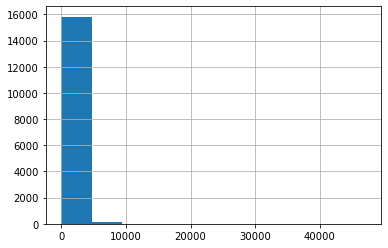

In [409]:
base_data.sales.hist()
plt.show()

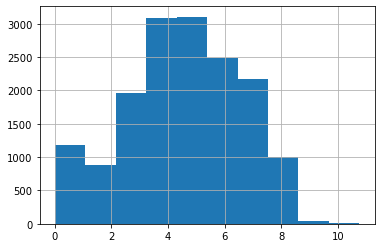

In [410]:
np.log(base_data.sales + 1).hist()
plt.show()

In [412]:
base_data['target'] = np.log(base_data.sales + 1)

In [457]:
train_data = base_data[base_data.date < datetime.datetime(2019, 9, 1)].reset_index(drop=True)
test_data = base_data[base_data.date.between(datetime.datetime(2019, 9, 1), 
                                             datetime.datetime(2019, 9, 30))].reset_index(drop=True)
predict_data = base_data[base_data.date.between(datetime.datetime(2019, 10, 1), 
                                                datetime.datetime(2019, 10, 31))].reset_index(drop=True)

In [458]:
prediction_df = predict_data[['date', 'hierarchy1_id', 'storetype_id', 'sales']].copy()

In [459]:
cat_cols = []
for column in train_cols:
    if train_data[column].dtype == 'object':
        cat_cols.append(column)

te_cv = None
if len(cat_cols) > 0:
    print('Categorical columns for target encoding: {}'.format(len(cat_cols)))
    print(cat_cols)
    te_cv = TargetEncoderCV(KFold(n_splits=3))
    train_data[cat_cols] = te_cv.fit_transform(train_data[cat_cols], train_data[target_col])
    test_data[cat_cols] = te_cv.transform(test_data[cat_cols])
    predict_data[cat_cols] = te_cv.transform(predict_data[cat_cols])

Categorical columns for target encoding: 2
['hierarchy1_id', 'storetype_id']


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


In [425]:
params = {
'max_bin' : [128],
'num_leaves': [8],
'reg_alpha' : [1.2],
'reg_lambda' : [1.2],
'min_data_in_leaf' : [50],
'bagging_fraction' : [0.5],
'learning_rate' : [0.001]
}

model = lgb.LGBMRegressor(n_estimators=10**5, n_jobs=-1, **params)

In [426]:
model.fit(train_data[train_cols], train_data[target_col], 
          eval_set = (test_data[train_cols], test_data[target_col]),
          eval_metric='rmse', verbose=1000, early_stopping_rounds=50)

[100]	valid_0's rmse: 2.11728	valid_0's l2: 4.48286
[200]	valid_0's rmse: 1.93058	valid_0's l2: 3.72714
[300]	valid_0's rmse: 1.76195	valid_0's l2: 3.10447
[400]	valid_0's rmse: 1.60967	valid_0's l2: 2.59104
[500]	valid_0's rmse: 1.47248	valid_0's l2: 2.16819
[600]	valid_0's rmse: 1.34883	valid_0's l2: 1.81934
[700]	valid_0's rmse: 1.23751	valid_0's l2: 1.53142
[800]	valid_0's rmse: 1.13779	valid_0's l2: 1.29457
[900]	valid_0's rmse: 1.04879	valid_0's l2: 1.09996
[1000]	valid_0's rmse: 0.969557	valid_0's l2: 0.940041
[1100]	valid_0's rmse: 0.898657	valid_0's l2: 0.807584
[1200]	valid_0's rmse: 0.835113	valid_0's l2: 0.697414
[1300]	valid_0's rmse: 0.77842	valid_0's l2: 0.605938
[1400]	valid_0's rmse: 0.728427	valid_0's l2: 0.530606
[1500]	valid_0's rmse: 0.684428	valid_0's l2: 0.468442
[1600]	valid_0's rmse: 0.64572	valid_0's l2: 0.416955
[1700]	valid_0's rmse: 0.611891	valid_0's l2: 0.374411
[1800]	valid_0's rmse: 0.582461	valid_0's l2: 0.339261
[1900]	valid_0's rmse: 0.55669	valid_0'

LGBMRegressor(bagging_fraction=[0.5], learning_rate=[0.001], max_bin=[128],
              min_data_in_leaf=[50], n_estimators=100000, num_leaves=[8],
              reg_alpha=[1.2], reg_lambda=[1.2])

## Feature Importance

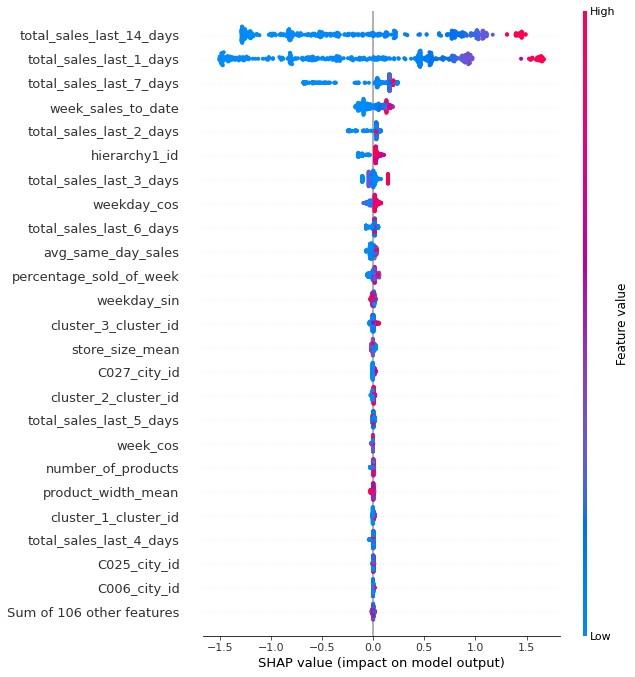

In [448]:
explainer = shap.TreeExplainer(model)

shap.plots.beeswarm(
                explainer(test_data[train_cols]),
                max_display=25
            )

## Recursive prediction

In [460]:
prediction_df['predicted'] = np.exp(model.predict(predict_data[train_cols])) - 1

In [461]:
prediction_pairs = prediction_df[['hierarchy1_id', 'storetype_id']].drop_duplicates()

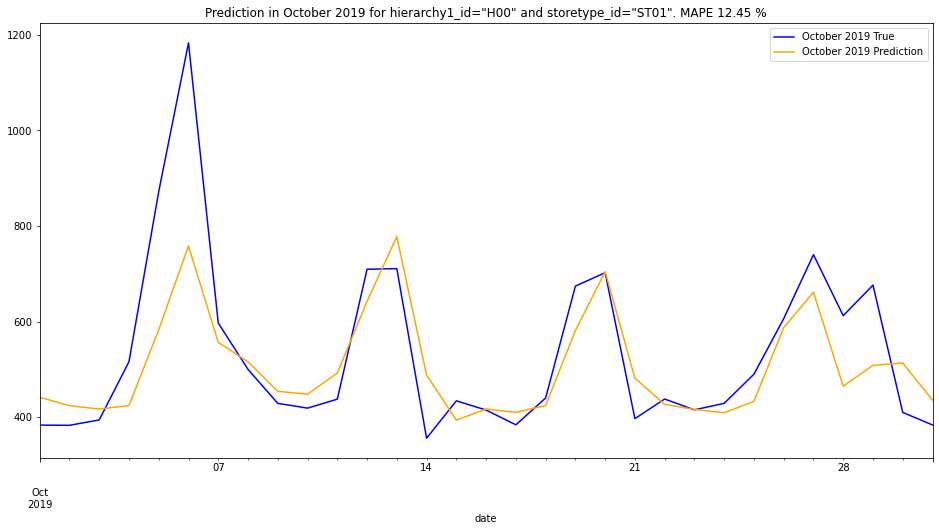

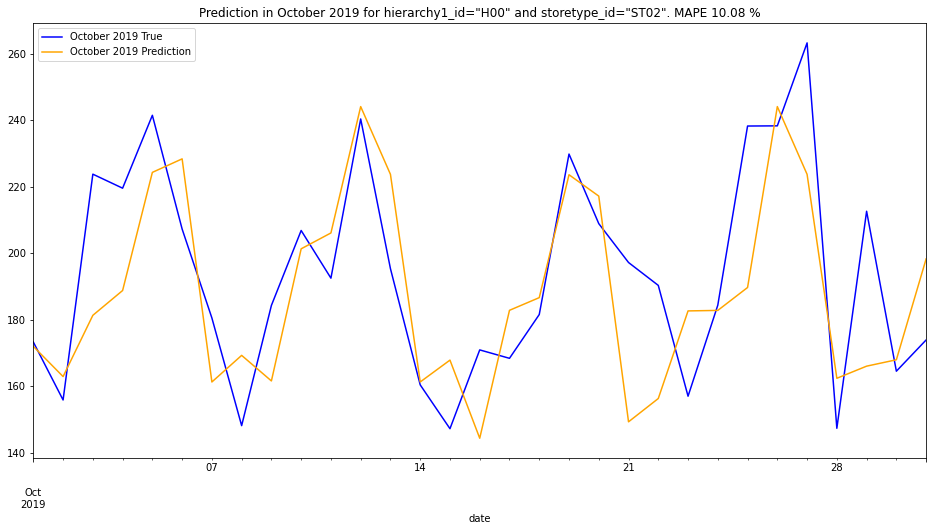

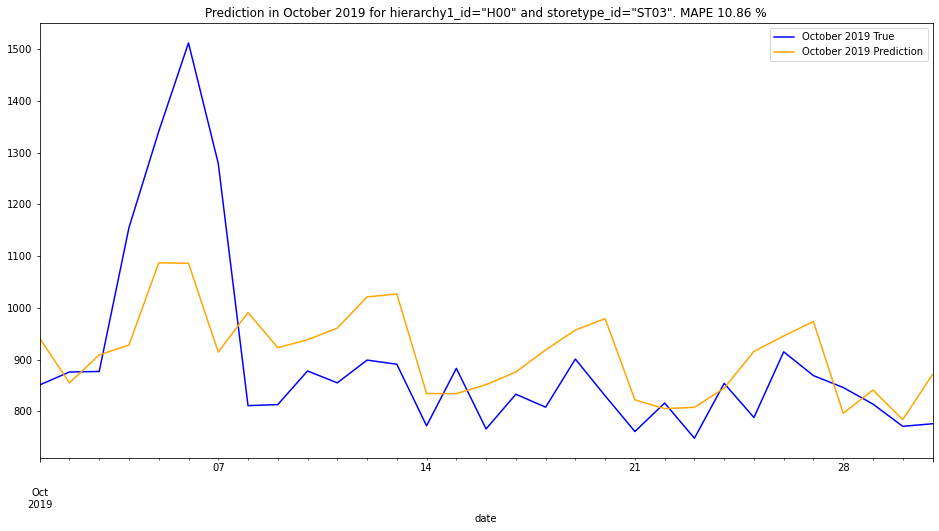

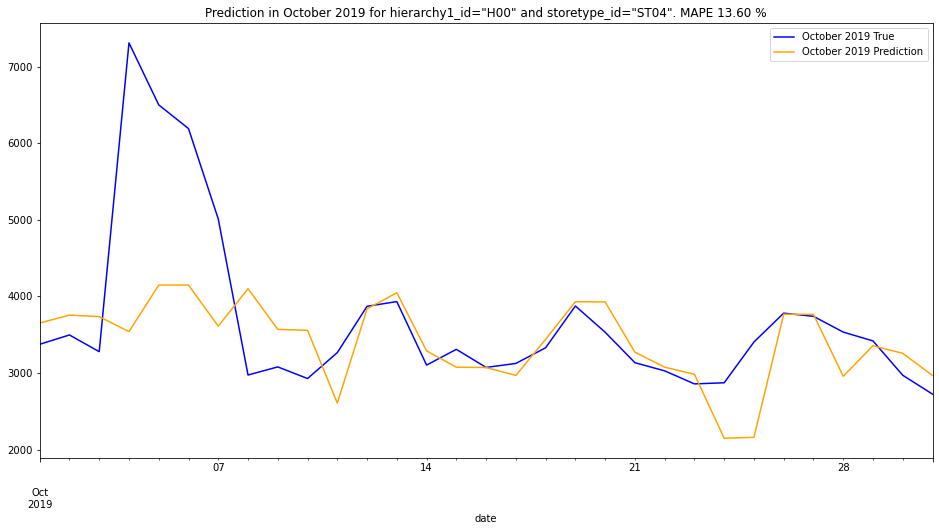

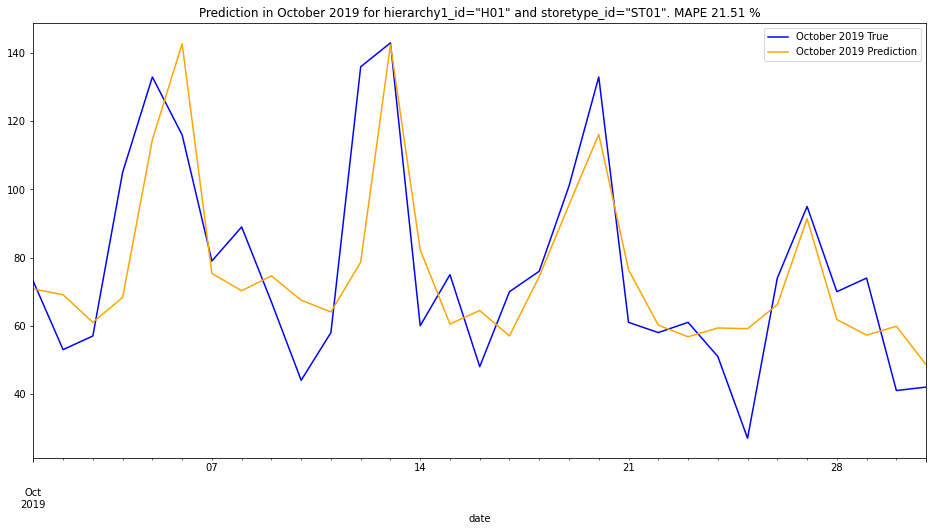

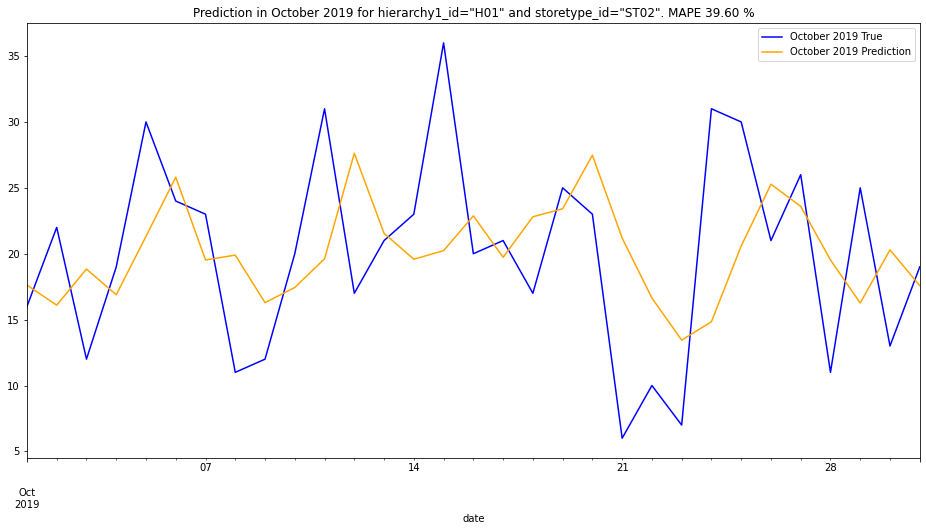

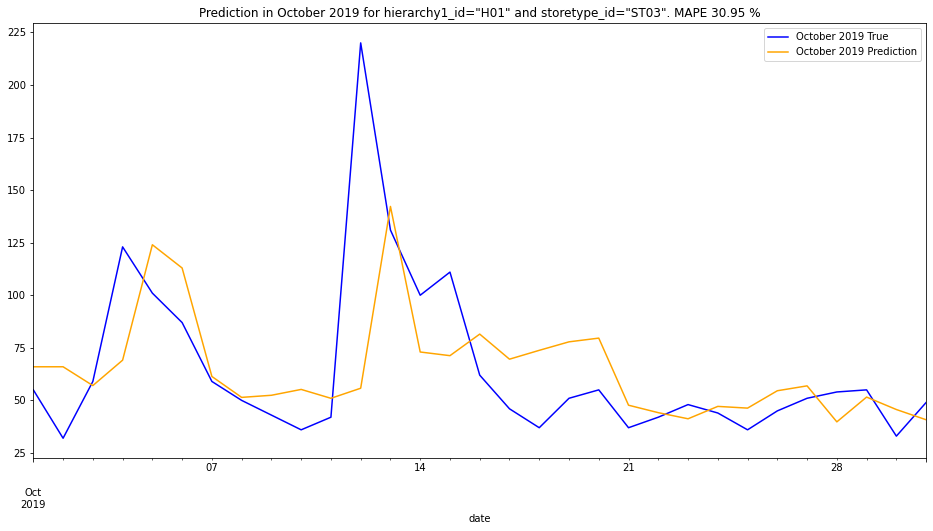

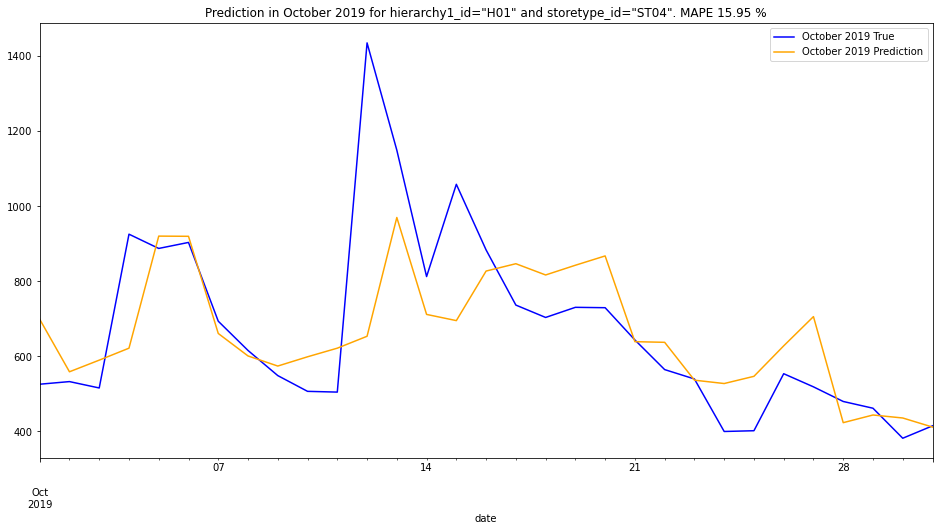

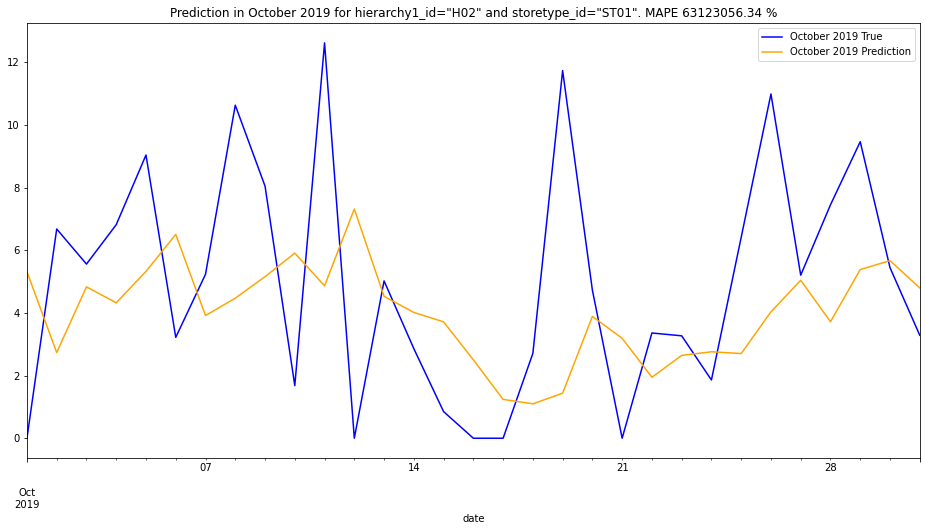

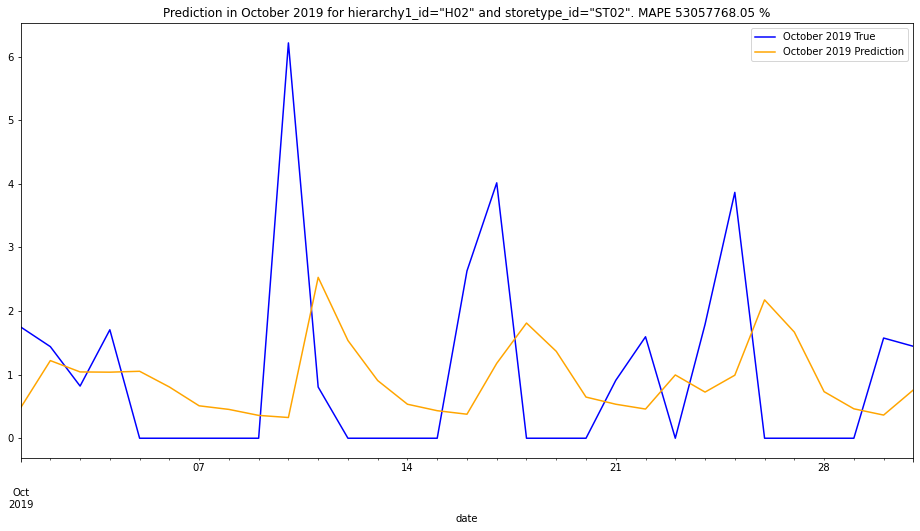

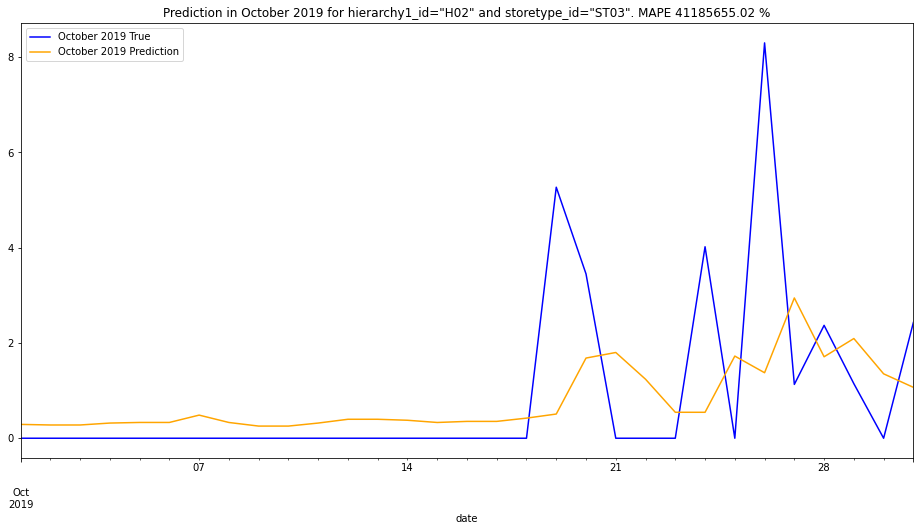

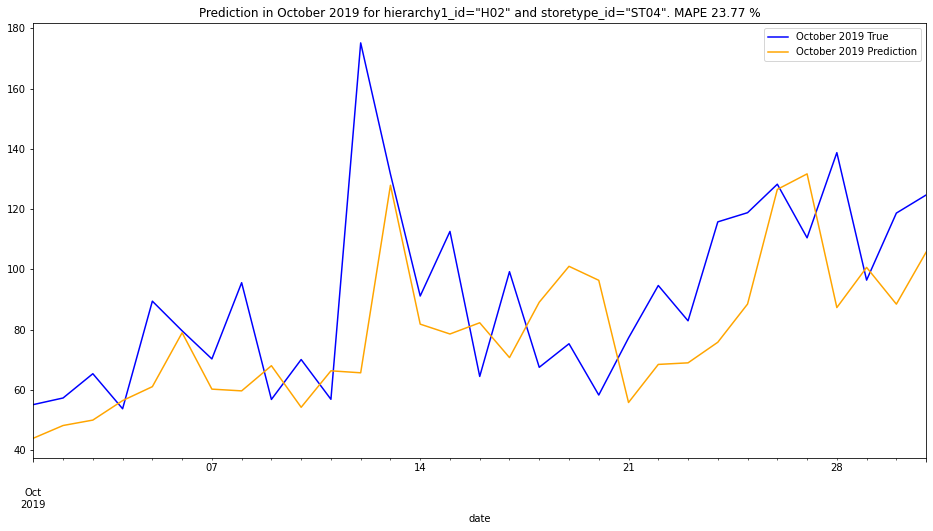

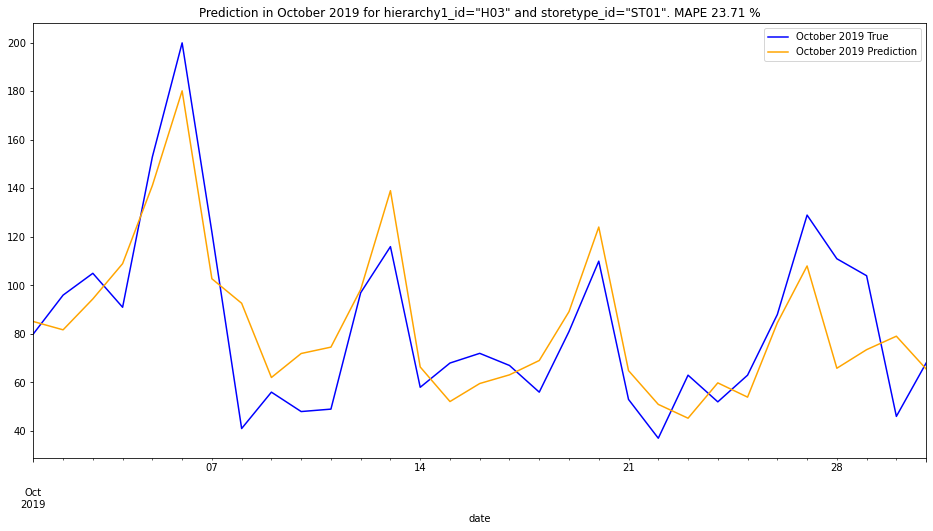

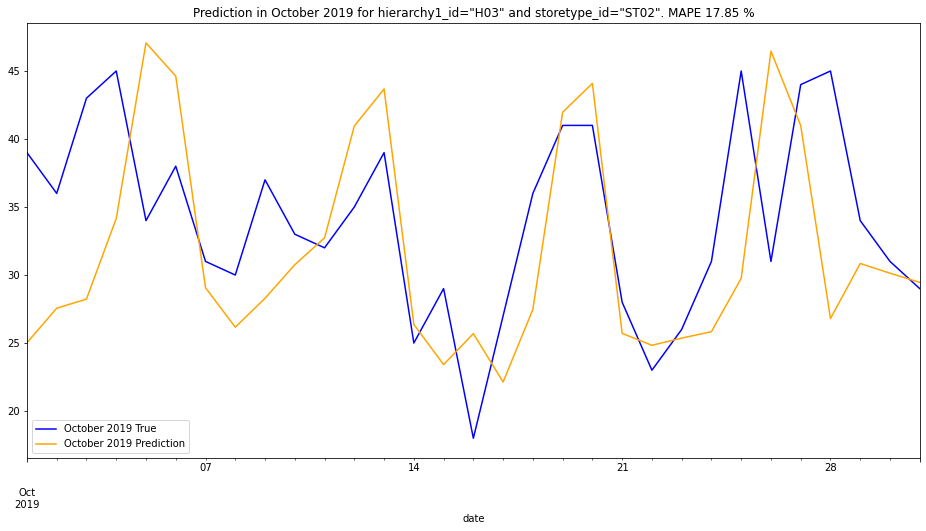

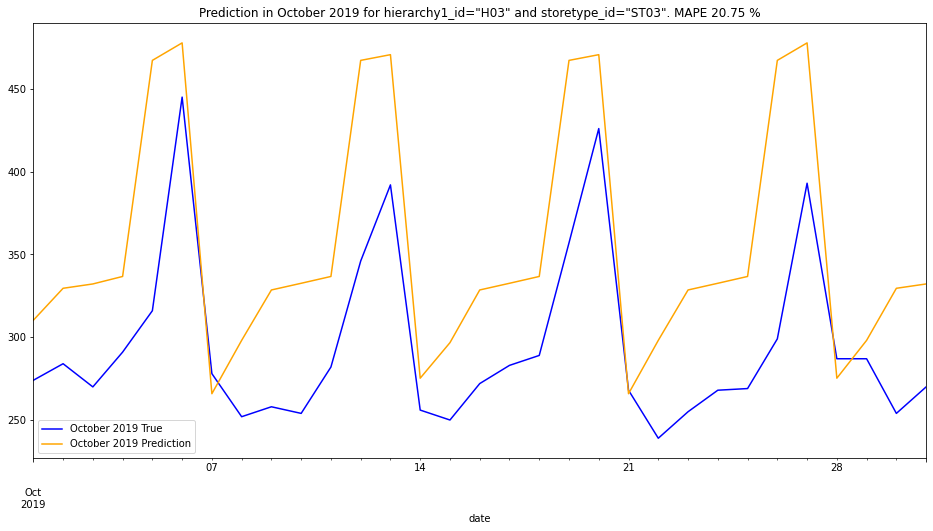

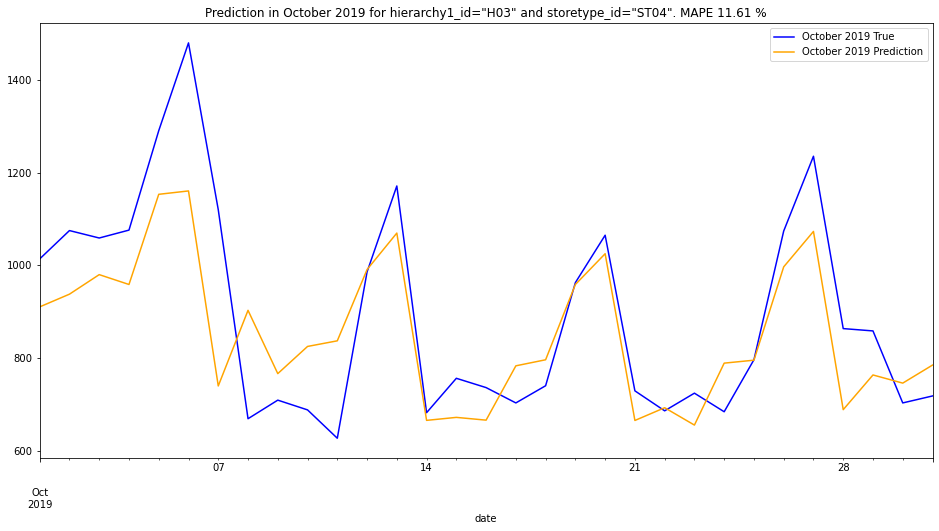

In [462]:
for pair in prediction_pairs.to_numpy():
    
    # Based on seasonal average
    
    
    # Plot charts
    prediction_df[(prediction_df.hierarchy1_id == pair[0]) & 
                    (prediction_df.storetype_id == pair[1])].set_index('date')['sales'].plot(figsize=(16,8), label='October 2019 True', c='blue')
    prediction_df[(prediction_df.hierarchy1_id == pair[0]) & 
                    (prediction_df.storetype_id == pair[1])].set_index('date')['predicted'].plot(figsize=(16,8), label='October 2019 Prediction', c='orange')
   
    mape_average = \
    MAPE(prediction_df[(prediction_df.hierarchy1_id == pair[0]) & 
                    (prediction_df.storetype_id == pair[1])]['sales'], prediction_df[(prediction_df.hierarchy1_id == pair[0]) & 
                    (prediction_df.storetype_id == pair[1])]['predicted'])
    
    plt.title('Prediction in October 2019 for hierarchy1_id="{0}" and storetype_id="{1}". MAPE {2:0.2f} %'\
                  .format(pair[0], pair[1], mape_average))
    plt.legend()
    plt.show()